# Nuclei Classification for Pathology

### Inference Notebook
It makes use of pretrained weights for the model from MONAI Bundle for Nuclei Classification.  However if you have trained model, you can use the same instead.

In [1]:
!python -c "import scipy" || pip install -q scipy
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.apps.nuclick.transforms import AddLabelAsGuidanced
from monai.apps.utils import download_and_extract
from monai.bundle import download
from monai.data import PILReader
from monai.networks.nets import DenseNet121
from monai.transforms import Activationsd, AsDiscreted, EnsureChannelFirstd, LoadImage, LoadImaged, ScaleIntensityRangeD
from monai.utils import convert_to_numpy
from PIL import Image
from scipy.io import loadmat

In [3]:
workspace_path = os.path.normpath('workspace/')
max_epochs = 1

## Define Model Path for Inference

Download Bundle for Nuclei classification model or Define your own path for pre-trained model for the same.

In [4]:
bundle_name = "pathology_nuclei_classification"
bundle_version = "0.0.1"

bundle_path = os.path.join(workspace_path, bundle_name)
if not os.path.exists(bundle_path):
    download(name=bundle_name, version=bundle_version, bundle_dir=workspace_path)

model_weights_path = os.path.join(bundle_path, "models", "model.pt")

2022-12-06 10:50:05,323 - INFO - --- input summary of monai.bundle.scripts.download ---
2022-12-06 10:50:05,325 - INFO - > name: 'pathology_nuclei_classification'
2022-12-06 10:50:05,326 - INFO - > version: '0.0.1'
2022-12-06 10:50:05,328 - INFO - > bundle_dir: 'workspace'
2022-12-06 10:50:05,329 - INFO - > source: 'github'
2022-12-06 10:50:05,330 - INFO - > repo: 'Project-MONAI/model-zoo/hosting_storage_v1'
2022-12-06 10:50:05,332 - INFO - > progress: True
2022-12-06 10:50:05,333 - INFO - ---




pathology_nuclei_classification_v0.0.1.zip: 50.8MB [00:03, 17.7MB/s]                                                                                                                                                                                           

2022-12-06 10:50:08,349 - INFO - Downloaded: workspace/pathology_nuclei_classification_v0.0.1.zip
2022-12-06 10:50:08,350 - INFO - Expected md5 is None, skip md5 check for file workspace/pathology_nuclei_classification_v0.0.1.zip.
2022-12-06 10:50:08,351 - INFO - Writing into directory: workspace.


In [5]:
class_names = {
    "0": "Other",
    "1": "Inflammatory",
    "2": "Epithelial",
    "3": "Spindle-Shaped",
}

device = torch.device("cuda")
network = DenseNet121(spatial_dims=2, in_channels=4, out_channels=len(class_names))

checkpoint = torch.load(model_weights_path, map_location=torch.device(device))
model_state_dict = checkpoint.get("model", checkpoint)
network.load_state_dict(model_state_dict, strict=True)

Can't initialize NVML


<All keys matched successfully>

## Per transform visualization for how the data gets prepared for inference

In [6]:
def show_image(image, label=None, sig=None, guidance=None, size=(12, 6)):
    if image.shape[0] == 3:
        image = np.moveaxis(image, 0, 2)
    if label is not None and label.shape[0] == 3:
        label = np.moveaxis(label, 0, 2)
    if label is not None and label.shape[0] == 1:
        label = label[0]

    plt.figure("check", size)
    m = 1
    n = 1
    if sig is not None:
        n = 3
    elif label is not None:
        n = 2
    plt.subplot(m, n, 1)

    plt.title("image")
    plt.imshow(image, cmap="gray")

    if label is not None:
        masked = np.ma.masked_where(label == 0, label)
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.5)

    if guidance is not None:
        colors = ['r+', 'b+']
        for color, points in zip(colors, guidance):
            for p in points:
                p1 = p[1]
                p2 = p[0]
                plt.plot(p1, p2, color, 'MarkerSize', 120)

    plt.colorbar()

    if label is not None:
        plt.subplot(m, n, 2)
        plt.title("pred" if sig is None else "This Nuclei")
        plt.imshow(label)
        plt.colorbar()
    if sig is not None:
        plt.subplot(m, n, 3)
        plt.title("Others Nuclei")
        plt.imshow(sig)
        plt.colorbar()
    plt.show()

In [7]:
consep_zip = 'https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep_dataset.zip'
consep_dir = os.path.join(workspace_path, 'CoNSeP')

if not os.path.exists(consep_dir):
    download_and_extract(consep_zip, output_dir=workspace_path)

consep_dataset.zip: 146MB [00:40, 3.76MB/s]                                                                                                                                                                                                                    

2022-12-06 10:50:51,968 - INFO - Downloaded: /tmp/tmpct_gfbvg/consep_dataset.zip
2022-12-06 10:50:51,970 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpct_gfbvg/consep_dataset.zip.
2022-12-06 10:50:51,972 - INFO - Writing into directory: workspace.


Image: torch.Size([128, 128, 3]); Label: torch.Size([128, 128]); Class: 3


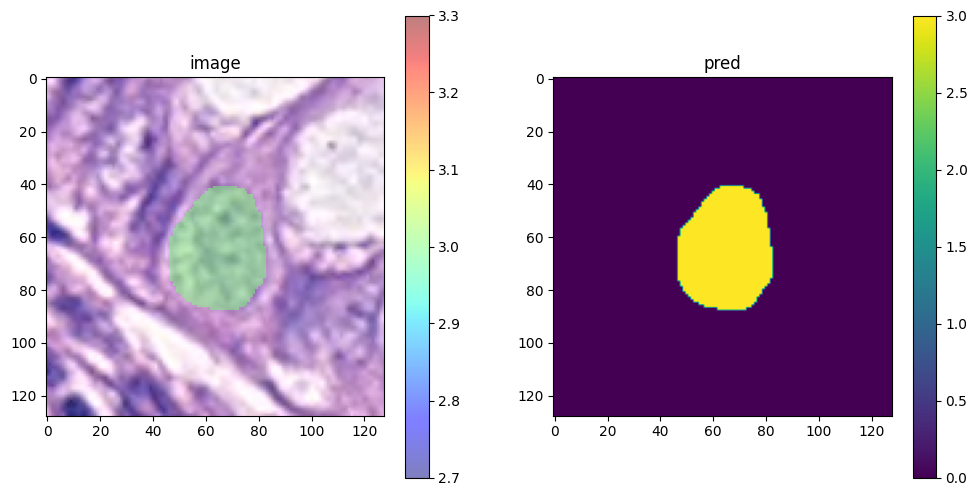

In [8]:
image_file = os.path.join(consep_dir, "Test", "Images", "test_12.png")
label_mat = os.path.join(consep_dir, "Test", "Labels", "test_12.mat")

crop_size = 128
image_cropped_file = os.path.join(workspace_path, "image_test_12_1.png")
label_cropped_file = os.path.join(workspace_path, "label_test_12_1.png")
label_class_id = None

# Label
m = loadmat(label_mat)
instances = m["inst_map"]
image = Image.open(image_file).convert("RGB")


def __compute_bbox(patch_size, centroid, size):
    x, y = centroid
    m, n = size

    x_start = int(max(x - patch_size / 2, 0))
    y_start = int(max(y - patch_size / 2, 0))
    x_end = x_start + patch_size
    y_end = y_start + patch_size
    if x_end > m:
        x_end = m
        x_start = m - patch_size
    if y_end > n:
        y_end = n
        y_start = n - patch_size
    return x_start, y_start, x_end, y_end


for nuclei_id, (class_id, (y, x)) in enumerate(zip(m["inst_type"], m["inst_centroid"]), start=1):
    x, y = (int(x), int(y))
    class_id = int(class_id)
    class_id = 3 if class_id in (3, 4) else 4 if class_id in (5, 6, 7) else class_id  # override

    image_np = np.array(image)
    image_size = image.size
    centroid = (x, y)

    bbox = __compute_bbox(crop_size, centroid, image_size)

    cropped_label_np = instances[bbox[0]: bbox[2], bbox[1]: bbox[3]]
    cropped_label_np = np.array(cropped_label_np)

    this_label = np.where(cropped_label_np == nuclei_id, class_id, 0)

    centroid = centroid[0] - bbox[0], centroid[1] - bbox[1]
    cropped_label_np = this_label
    cropped_label = Image.fromarray(cropped_label_np.astype(np.uint8), None)

    cropped_image_np = image_np[bbox[0]: bbox[2], bbox[1]: bbox[3], :]
    cropped_image = Image.fromarray(cropped_image_np.astype(np.uint8), "RGB")

    cropped_image.save(image_cropped_file)
    cropped_label.save(label_cropped_file)
    label_class_id = class_id
    break


image_np = LoadImage(image_only=True, dtype=np.uint8, reader=PILReader(
    converter=lambda im: im.convert("RGB")))(image_cropped_file)
label_np = LoadImage(image_only=True, dtype=np.uint8, reader=PILReader(
    converter=lambda im: im.convert("L")))(label_cropped_file)

print(f"Image: {image_np.shape}; Label: {label_np.shape}; Class: {label_class_id}")
show_image(image_np, label_np)

## Inference example using the transforms with a prediction from the network

--------------------------------------------------------------------------
1 => Transform: LoadImaged
Image: torch.Size([128, 128, 3]); Label: torch.Size([128, 128])


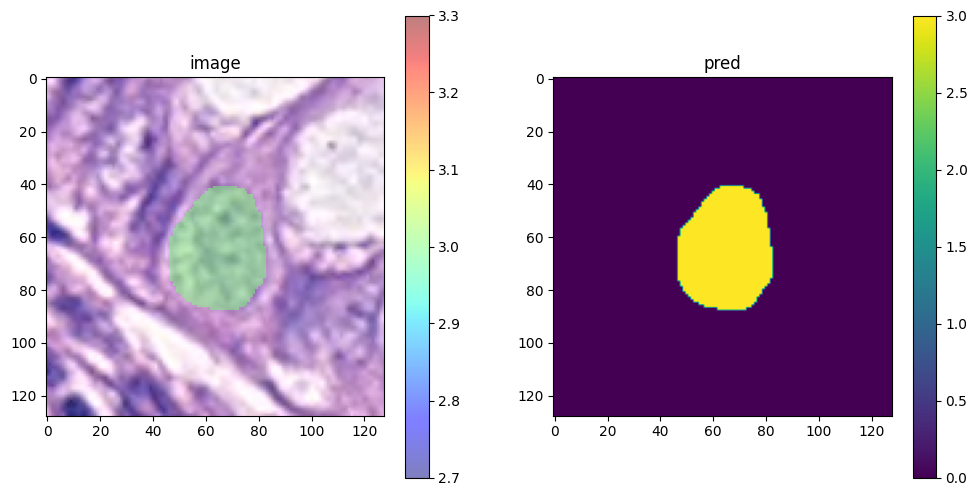

--------------------------------------------------------------------------
2 => Transform: EnsureChannelFirstd
Image: torch.Size([3, 128, 128]); Label: torch.Size([1, 128, 128])


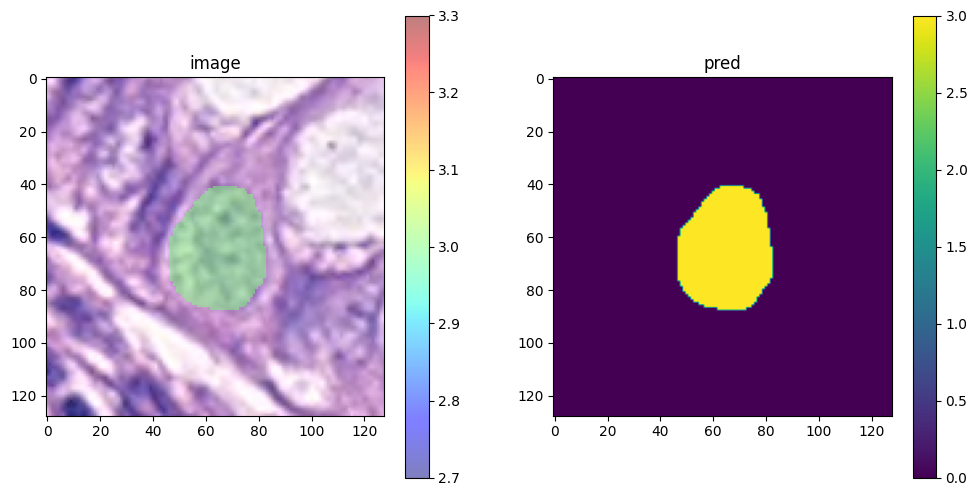

--------------------------------------------------------------------------
3 => Transform: ScaleIntensityRanged
Image: torch.Size([3, 128, 128]); Label: torch.Size([1, 128, 128])
2022-12-06 10:50:57,010 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


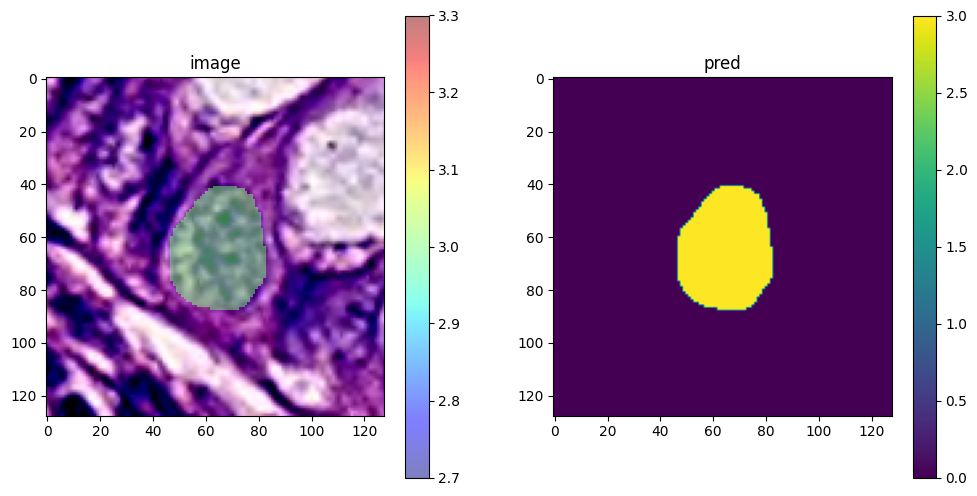

--------------------------------------------------------------------------
4 => Transform: AddLabelAsGuidanced
Image: torch.Size([4, 128, 128]); Label: torch.Size([1, 128, 128])
2022-12-06 10:50:57,823 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


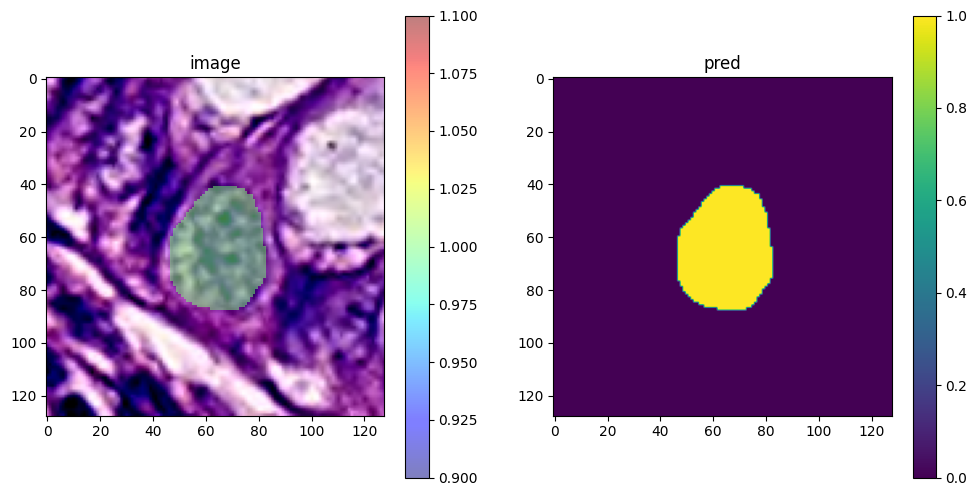

In [9]:
# Transforms
pre_transforms = [
    LoadImaged(keys="image", dtype=np.uint8, reader=PILReader(converter=lambda im: im.convert("RGB"))),
    LoadImaged(keys="label", dtype=np.uint8, reader=PILReader(converter=lambda im: im.convert("L"))),
    EnsureChannelFirstd(keys=("image", "label")),
    ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
    AddLabelAsGuidanced(keys="image", source="label"),
]

data = {"image": image_cropped_file, "label": label_cropped_file}

for tidx, t in enumerate(pre_transforms):
    tname = type(t).__name__
    data = t(data)
    if tidx == 0:
        continue

    print("--------------------------------------------------------------------------")
    print(f"{tidx} => Transform: {tname}")
    print(f"Image: {data['image'].shape}; Label: {data['label'].shape}")
    if tname == "AddLabelAsGuidanced":
        show_image(convert_to_numpy(data["image"][:3]), label=data["image"][3])
    else:
        show_image(convert_to_numpy(data["image"]), label=data["label"])

In [10]:
network.eval()
with torch.no_grad():
    pred = network(data["image"][None])[0]

print(f"Pred: {pred.shape}; Pred: {pred}")

Pred: torch.Size([4]); Pred: tensor([-3.8777, -6.4293,  6.6550, -0.3951])


In [11]:
# Transforms
post_transforms = [
    Activationsd(keys="pred", softmax=True),
    AsDiscreted(keys="pred", argmax=True),
]

data["pred"] = pred

for t in post_transforms:
    tname = type(t).__name__
    data = t(data)
    print("--------------------------------------------------------------------------")
    print(f"Transform: {tname}")
    print(f"Pred: {data['pred'] if tname != 'AsDiscreted' else class_names[str(int(data['pred']))]}")

--------------------------------------------------------------------------
Transform: Activationsd
Pred: tensor([2.6625e-05, 2.0756e-06, 9.9910e-01, 8.6655e-04])
--------------------------------------------------------------------------
Transform: AsDiscreted
Pred: Epithelial


## End of Notebook